importing the necessary tools

In [1]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")



/home/aymane/churn/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

churn_df  = pd.read_csv(path+"/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col= 'customerID')
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


inspecting the dataset in dataframe

In [3]:
%load_ext autoreload
%autoreload 2
from inspecting_tools import quick_inspect, check_unique_values, check_missing_data

quick_inspect(churn_df)
print(check_missing_data(churn_df))
check_unique_values(churn_df)


(7043, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     704

So from this we see that this data frame contains no missing values, but most columns are categorical

And the TotalCharges column also contains abject type instead of a float, so it needs to be fixed

In [4]:
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
#  Force convert TotalCharges to numeric.
# 'coerce' turns bad values (like " ") into NaN

In [5]:
#let's see now if we get any missing values in TotalCharges
print(check_missing_data(churn_df))

              Null_Count  Percentage
TotalCharges          11    0.001562


In [6]:
#based on the percentage the number of missing values is very low so we just drop those rows
churn_df.dropna(inplace=True)
print(check_missing_data(churn_df))


Empty DataFrame
Columns: [Null_Count, Percentage]
Index: []


In [7]:
#spliting the dataframe 
from sklearn.model_selection import train_test_split

X = churn_df.drop('Churn', axis=1)
y = churn_df.Churn
y = y.map({'Yes':1, 'No':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)
print(f"Training shape {X_train.shape}")
print(f"Testing shape {X_test.shape}")


Training shape (5977, 19)
Testing shape (1055, 19)


In [8]:
#grouping the columns from numirical and categorical
obj_cols = [cname for cname in X.columns if X[cname].dtypes == 'object']
num_cols = [cname for cname in X.columns if X[cname].dtypes in ['int64' ,'float64']]
print(f"Categorical columns ({len(obj_cols)}): {obj_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

num_transformer = SimpleImputer(strategy="median")
obj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor  = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', obj_transformer, obj_cols)
])

model = XGBClassifier(
    n_estimators=500,       # Number of trees (committee size)
    learning_rate=0.05,     # Step size (prevents overfitting)
    n_jobs=4,               # Parallel processing
    random_state=42
)

churn_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
churn_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.82      0.90      0.86       763
           1       0.65      0.50      0.56       292

    accuracy                           0.79      1055
   macro avg       0.74      0.70      0.71      1055
weighted avg       0.77      0.79      0.78      1055



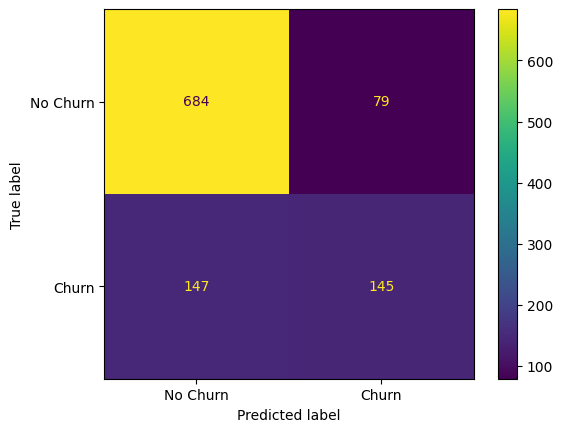

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

y_pred = churn_pipeline.predict(X_test)
y_proba = churn_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()

ROC-AUC Score: 0.8270


<Figure size 1000x600 with 0 Axes>

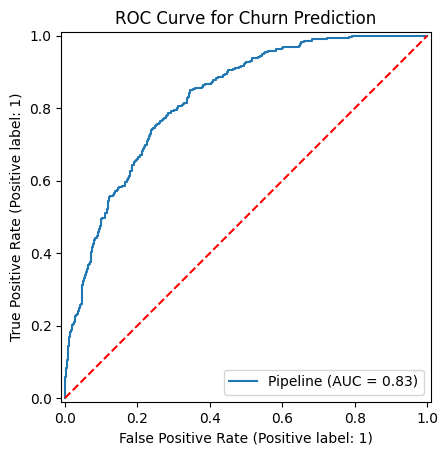

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


plt.figure(figsize=(10, 6))

# Ploting the ROC Curve directly from the pipeline
RocCurveDisplay.from_estimator(churn_pipeline, X_test, y_test)

# Add the diagonal dashed line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.title('ROC Curve for Churn Prediction')
plt.show()